In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import pytz
import re

# 1. Function to convert epoch to a CST datetime object
def convert_epoch_to_cst_datetime(epoch, cst):
    utc_time = datetime.utcfromtimestamp(epoch).replace(tzinfo=pytz.utc)
    return utc_time.astimezone(cst)

# 2. Function to create 'submitInterval' column based on time of day
def get_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

# 3. Function to read CSV file
def read_csv(file_path):
    return pd.read_csv(file_path)

# 4. Function to convert 'submitTime', 'startTime', and 'endTime' to CST
def convert_time_columns(df, cst):
    df['submitTime'] = df['submitTime'].apply(lambda x: convert_epoch_to_cst_datetime(x, cst))
    df['startTime'] = df['startTime'].apply(lambda x: convert_epoch_to_cst_datetime(x, cst))
    df['endTime'] = df['endTime'].apply(lambda x: convert_epoch_to_cst_datetime(x, cst))
    return df

# 5. Function to calculate 'pendTime'
def calculate_pend_time(df):
    df['pendTime'] = (df['startTime'] - df['submitTime']).dt.total_seconds()
    return df

# 6. Function to add 'submitInterval' and 'submitDay' columns
def add_time_of_day_and_day(df):
# Define the desired order for submitDay and submitInterval
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    interval_order = ['Morning', 'Afternoon', 'Evening', 'Night']
    
    # Add submitInterval and submitDay columns
    df['submitInterval'] = df['submitTime'].dt.hour.apply(get_time_of_day)
    df['submitDay'] = df['submitTime'].dt.day_name()
    
    # Set categorical ordering for submitDay and submitInterval
    df['submitDay'] = pd.Categorical(df['submitDay'], categories=day_order, ordered=True)
    df['submitInterval'] = pd.Categorical(df['submitInterval'], categories=interval_order, ordered=True)

    return df

# 7. Function to overwrite 'queue' after replacing 'rhel8_' and 'rhel88_'
def overwrite_queue(df):
    df['queue'] = df['queue'].str.replace(r'rhel8_', '', regex=True)
    df['queue'] = df['queue'].str.replace(r'rhel88_', '', regex=True)
    return df

# 8. Function to extract memory from 'resReq' and overwrite existing values
def extract_requested_memory(df):
    df['resReq'] = df['resReq'].astype(str)
    df['requested_memory'] = df['resReq'].apply(lambda resReq: float(re.search(r'mem=(\d+(\.\d+)?)', resReq).group(1)) if re.search(r'mem=(\d+(\.\d+)?)', resReq) else None)
    return df.dropna(subset=['requested_memory'])

# 9. Function to convert 'maxRMem' from KB to MB
def convert_max_rmem(df):
    df['maxRMem'] = df['maxRMem'] / 1024
    return df

# 10. Function to create the 'userCancelJob' indicator variable
def create_user_cancel_job(df):
    df['userCancelJob'] = np.where(df['pendTime'] < 0, 1, 0)
    return df

# 11. Function to filter rows where 'userCancelJob' is greater than 0
def remove_user_cancel_job(df):
    return df[df['userCancelJob'] == 0]

# 12. Function to order the 'queue' variable based on value counts
def order_queue_by_value_counts(df):
    queue_counts = df['queue'].value_counts()
    ordered_queues = queue_counts.index
    df['queue'] = pd.Categorical(df['queue'], categories=ordered_queues, ordered=True)
    return df

#13. Define Job category based on Job distribution
def define_job_category(df):
    # Calculate percentiles for runTime
    df_done = df[df['jStatus'] == 'done']
    short_threshold = df['runTime'].quantile(0.75)
    long_threshold = df['runTime'].quantile(0.95)
    verylong_threshold = df['runTime'].quantile(0.99)
    # Define job categories based on runTime
    conditions = [
        (df['runTime'] <= short_threshold),
        (df['runTime'] > short_threshold) & (df['runTime'] <= long_threshold),
        (df['runTime'] > long_threshold) & (df['runTime'] <= verylong_threshold),
        (df['runTime'] > verylong_threshold)
    ]
    
    # Assign labels to the categories
    categories = ['Short', 'Medium', 'Long', 'Very Long']
    
    # Create a new column 'jobCategory' based on the conditions
    df['jobCategory'] = np.select(conditions, categories)
    
    # Ensure 'jobCategory' is an ordered categorical variable
    df['jobCategory'] = pd.Categorical(df['jobCategory'], 
                                       categories=['Short', 'Medium', 'Long', 'Very Long'],
                                       ordered=True)
    return df


###14. Calculate the memory utilization 
def calculate_and_categorize_memutilization(df):
    # Calculate memory utilization
    df.loc[df['numProcessors'] > 0, 'memUtilization'] = (df['maxRMem'] / (df['numProcessors'] * df['requested_memory'])) * 100
    df.loc[df['numProcessors'] == 0, 'memUtilization'] = 0

    # Replace inf and nan with 0
    df['memUtilization'].replace([np.inf, -np.inf], 0, inplace=True)
    df['memUtilization'].fillna(0, inplace=True)

    # Calculate percentiles
    percentiles = df['memUtilization'].quantile([0.50, 0.75, 0.95])
    
    # Define categories based on percentiles
    def categorize_utilization(utilization):
        if utilization <= percentiles[0.50]:
            return 'Low'
        elif utilization <= percentiles[0.75]:
            return 'Medium'
        elif utilization <= percentiles[0.95]:
            return 'High'
        else:
            return 'Very High'
    
    # Apply categorization
    df['memUtilizationCat'] = df['memUtilization'].apply(categorize_utilization)

    return df


# 15. Main preprocessing function
def modelProcess_csv(file_path):
    cst = pytz.timezone('US/Central')  # Define CST timezone    
    # Step-by-step preprocessing
    df = read_csv(file_path)
    df = convert_time_columns(df, cst)
    df = calculate_pend_time(df)
    df = add_time_of_day_and_day(df)
    df = overwrite_queue(df)
    df = extract_requested_memory(df)
    df = convert_max_rmem(df)
    df = create_user_cancel_job(df)
    df = remove_user_cancel_job(df)  # Keep only rows where userCancelJob > 0
    df = order_queue_by_value_counts(df)  # Order the 'queue' column by value counts
    df = define_job_category(df) #Categorize job to short/intermediate/long
    df = calculate_and_categorize_memutilization(df) ## calculate and categorize memory utilization

    # Display the filtered dataframe
    #print(df.head())
    #print(df.shape[0])

    return df



In [ ]:
# Example usage:
file_path = '../common/finished_jobs_1_week.csv'
df_preprocessed = modelProcess_csv(file_path)
print(df_preprocessed.head())
print(df_preprocessed.tail())

   userId      jobId  jobIdx  numProcessors jStatus                submitTime  \
0   69430  233656568       0              4    exit 2024-08-19 00:01:34-05:00   
1  107357  233656570       0              4    done 2024-08-19 00:04:52-05:00   
2  107357  233656569       0              4    done 2024-08-19 00:04:52-05:00   
3  107357  233656571       0              4    done 2024-08-19 00:04:52-05:00   
4  107357  233656572       0              4    done 2024-08-19 00:04:53-05:00   

                  startTime                   endTime   queue  \
0 2024-08-19 00:01:39-05:00 2024-08-19 00:08:45-05:00  cryoem   
1 2024-08-19 00:04:54-05:00 2024-08-19 09:43:11-05:00     gpu   
2 2024-08-19 00:04:54-05:00 2024-08-19 09:45:44-05:00     gpu   
3 2024-08-19 00:04:54-05:00 2024-08-19 10:03:02-05:00     gpu   
4 2024-08-19 00:04:54-05:00 2024-08-19 09:44:03-05:00     gpu   

                               resReq  ...  cpuTime runTime  pendTime  \
0                   rusage[mem=20000]  ...    123

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Select the relevant columns

columns_of_interest = [
    'runTime', 'numProcessors', 'jStatus', 'queue', 'jobCategory', 'memUtilizationCat',
    'requested_memory', 'pendTime', 'submitDay', 'submitInterval', 
    'maxRMem', 'memUtilization'
]

df_subset = df_preprocessed[columns_of_interest]

print(df_subset.head())



   runTime  numProcessors jStatus   queue jobCategory memUtilizationCat  \
0      426              4    exit  cryoem      Medium               Low   
1    34697              4    done     gpu   Very Long               Low   
2    34850              4    done     gpu   Very Long               Low   
3    35888              4    done     gpu   Very Long               Low   
4    34749              4    done     gpu   Very Long               Low   

   requested_memory  pendTime submitDay submitInterval  maxRMem  \
0           20000.0       5.0    Monday          Night   2203.0   
1           24576.0       2.0    Monday          Night    315.0   
2           24576.0       2.0    Monday          Night    326.0   
3           24576.0       2.0    Monday          Night    322.0   
4           24576.0       1.0    Monday          Night    315.0   

   memUtilization  
0        2.753750  
1        0.320435  
2        0.331624  
3        0.327555  
4        0.320435  


In [ ]:
# Calculate correlations
correlation_matrix = df_subset.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the heatmap using matplotlib, masking the upper triangle
plt.figure(figsize=(12, 10))

# Mask the upper triangle by applying the mask to the data
masked_corr = np.ma.masked_where(mask, correlation_matrix)

# Use imshow to plot the lower triangular part only
plt.imshow(masked_corr, cmap='coolwarm', interpolation='none')
plt.colorbar()

# Add labels
plt.xticks(np.arange(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(np.arange(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title('Lower Triangular Correlation Matrix')

# Show the plot
plt.tight_layout()
plt.savefig('lower_triangular_correlation_matrix.png')
plt.show()

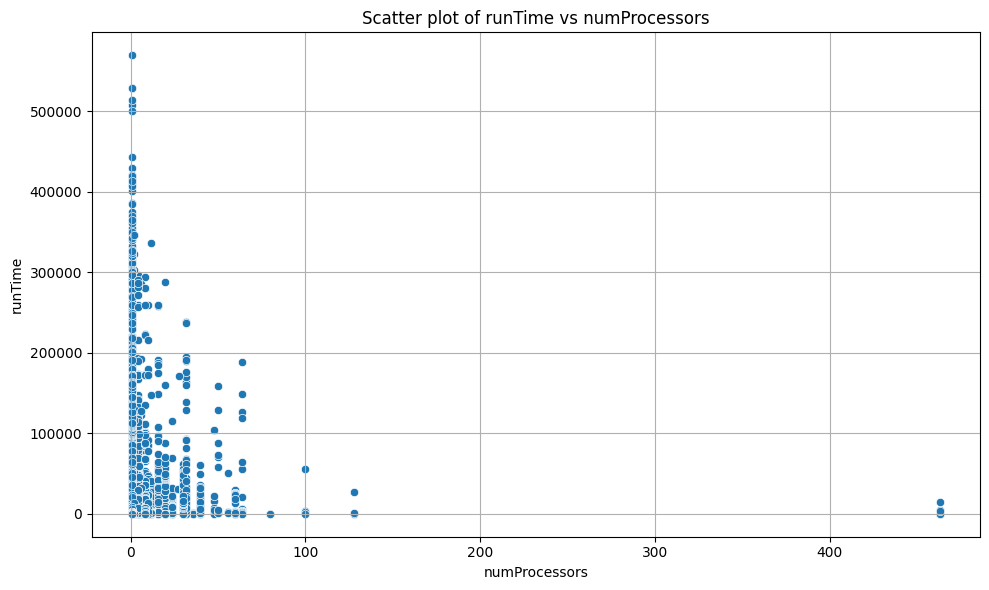

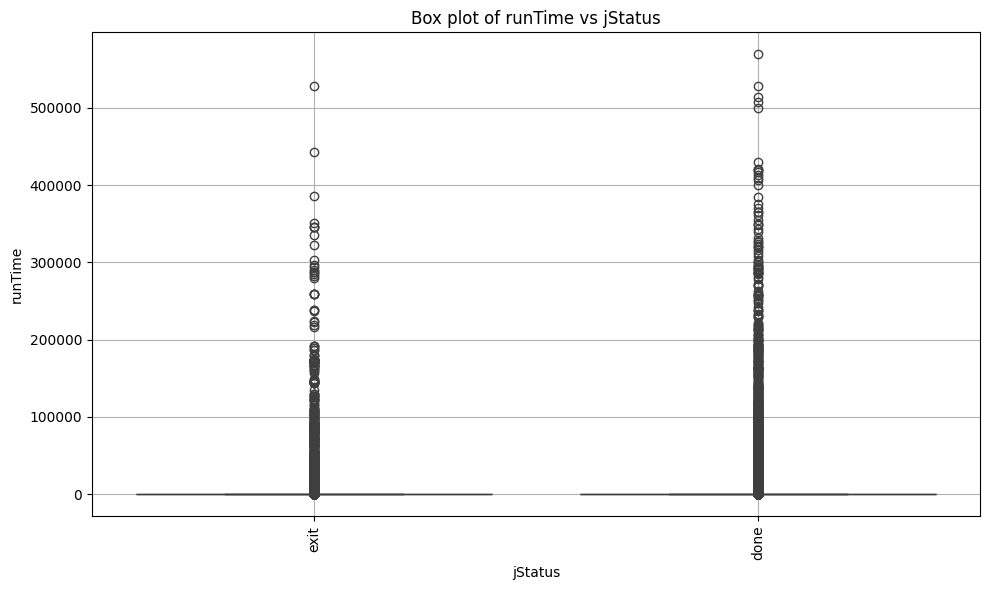

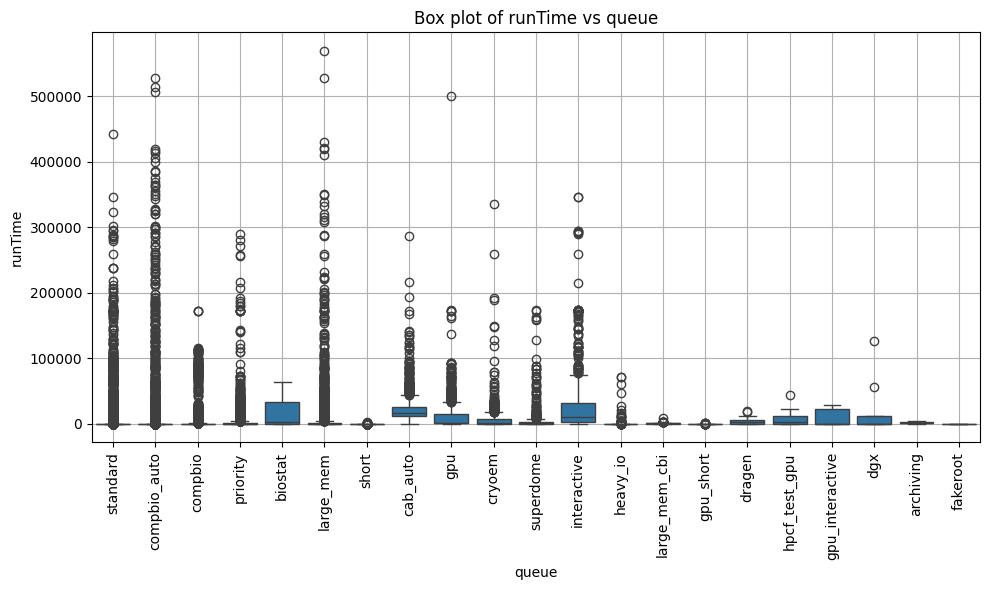

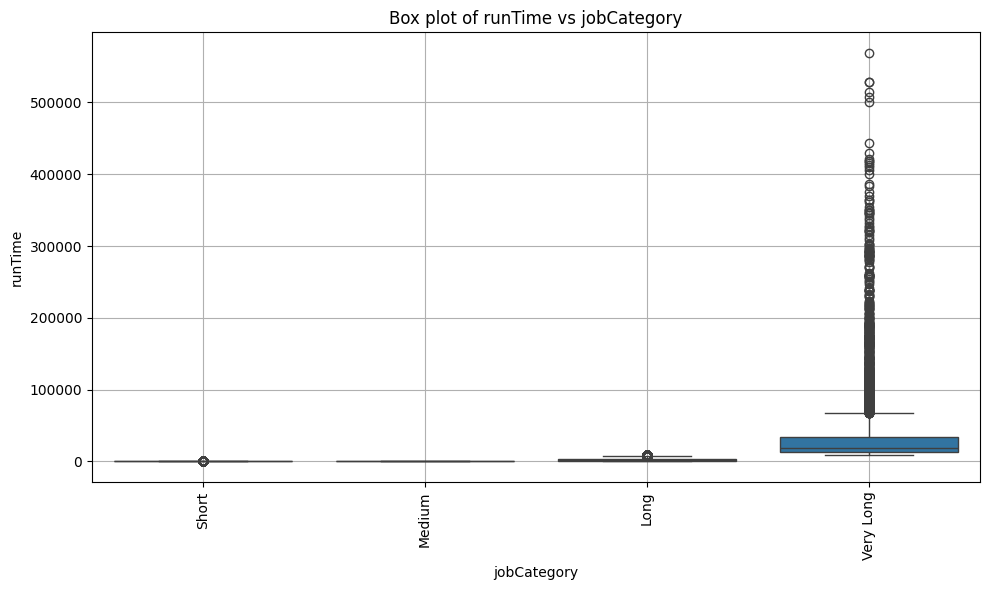

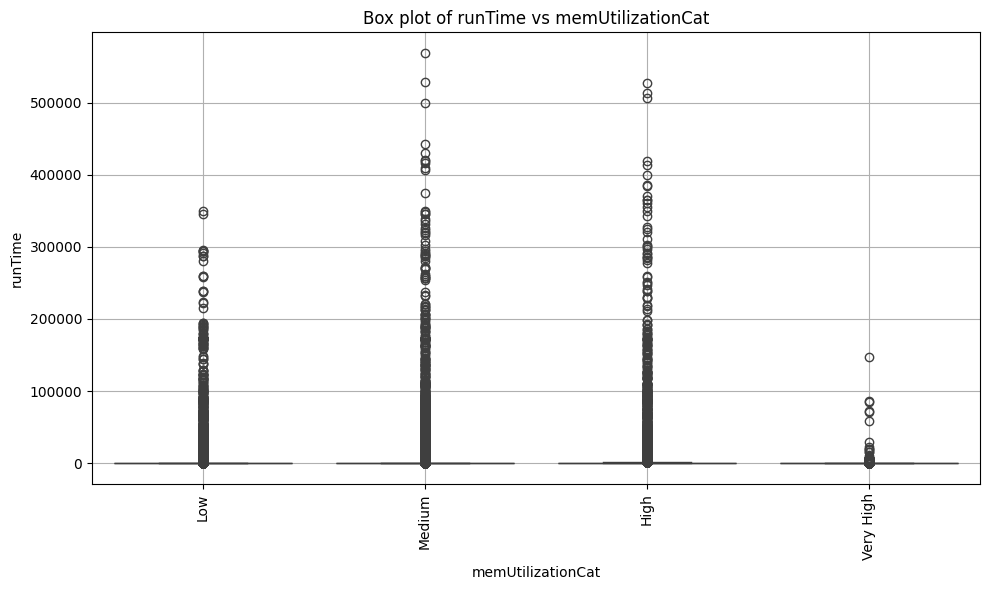

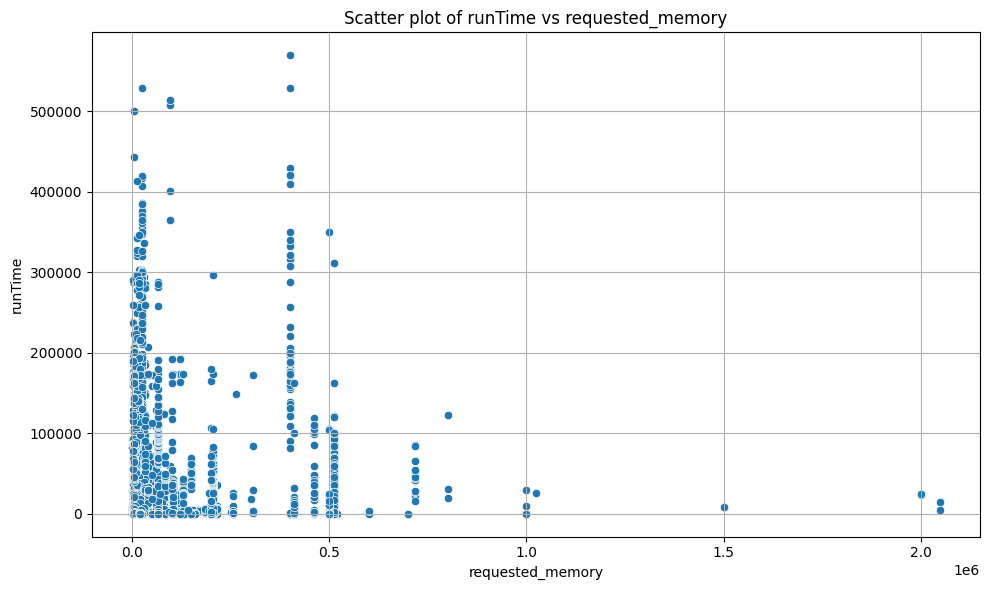

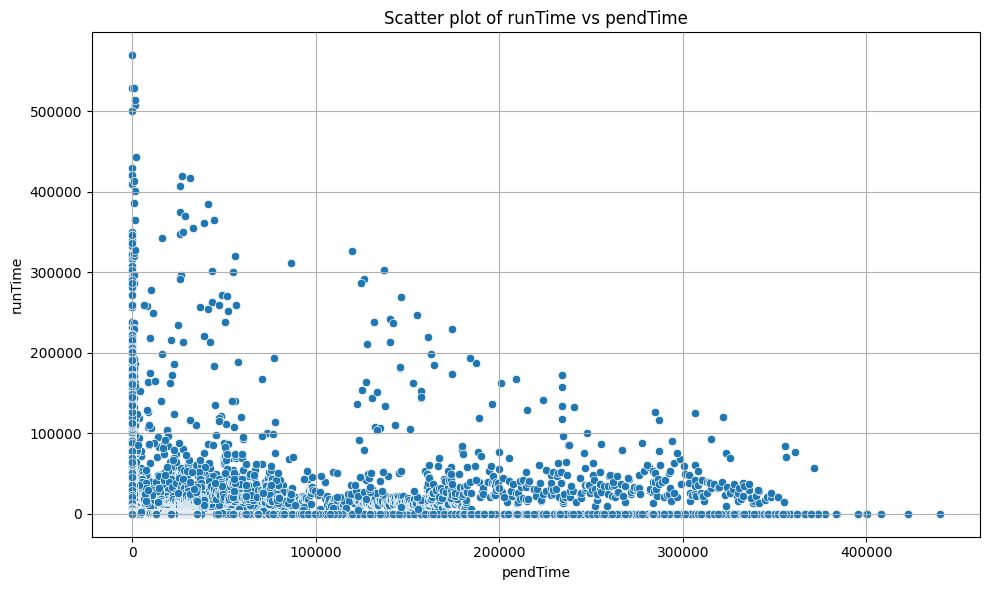

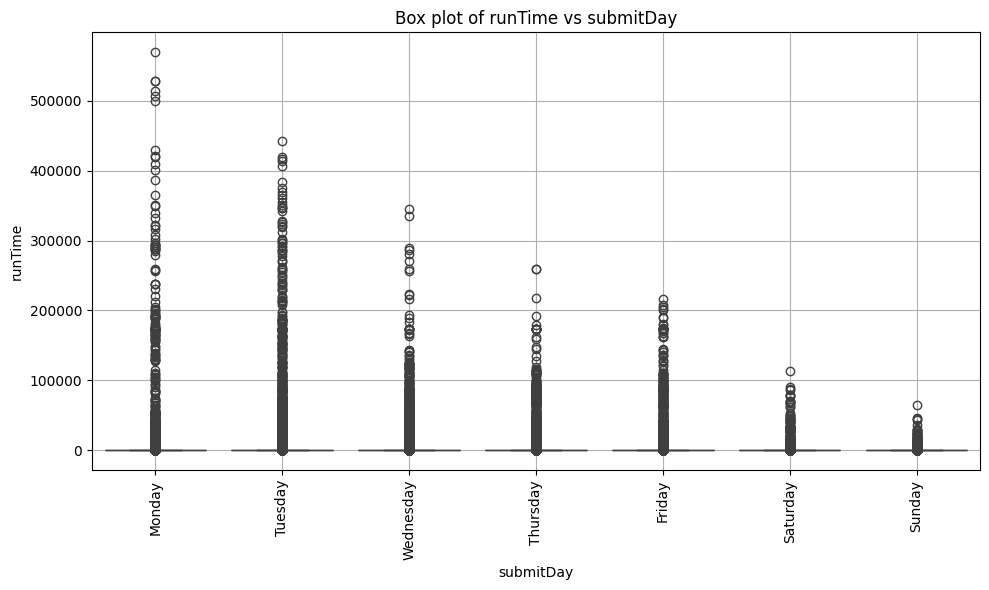

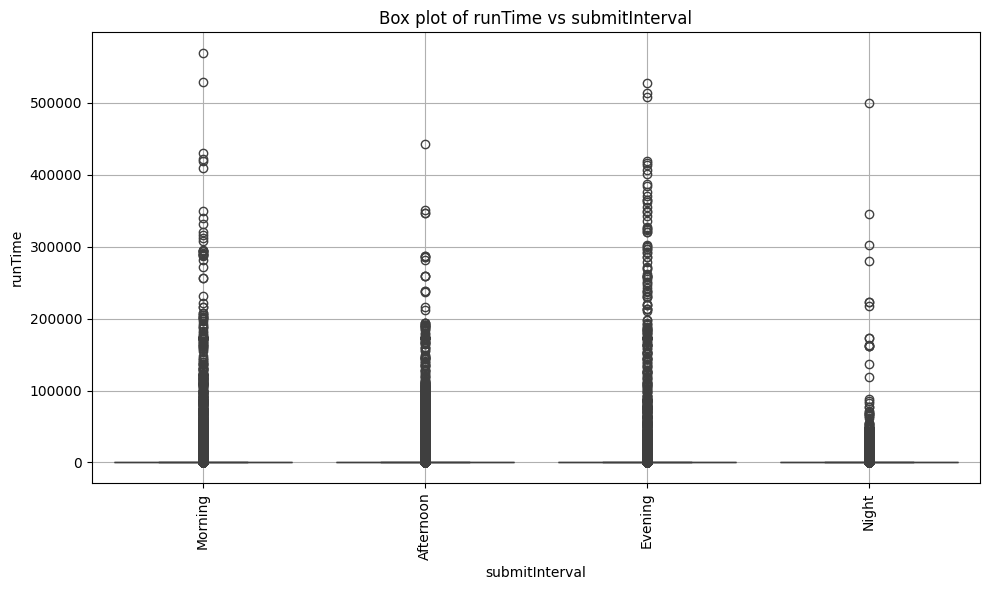

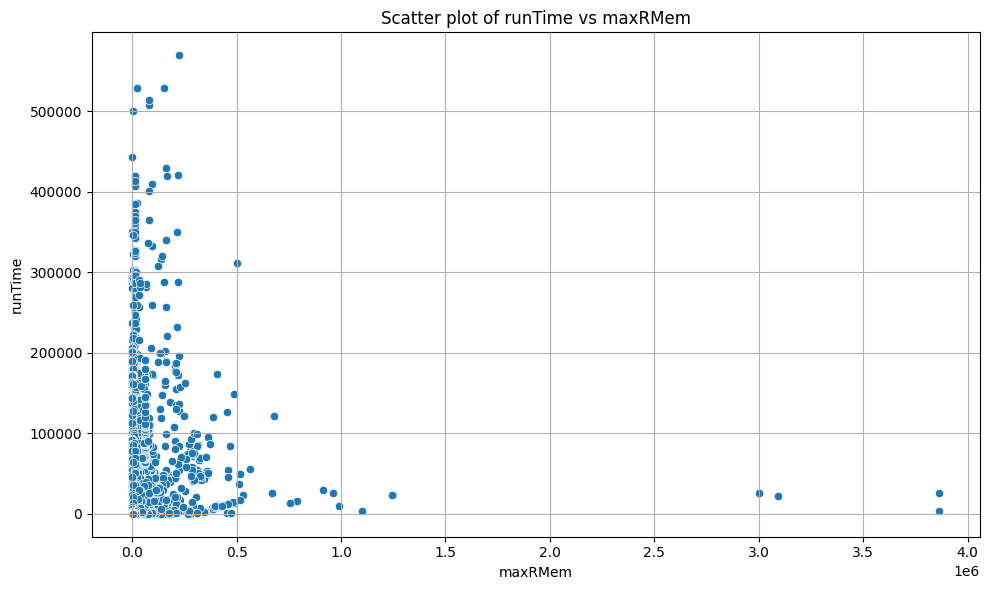

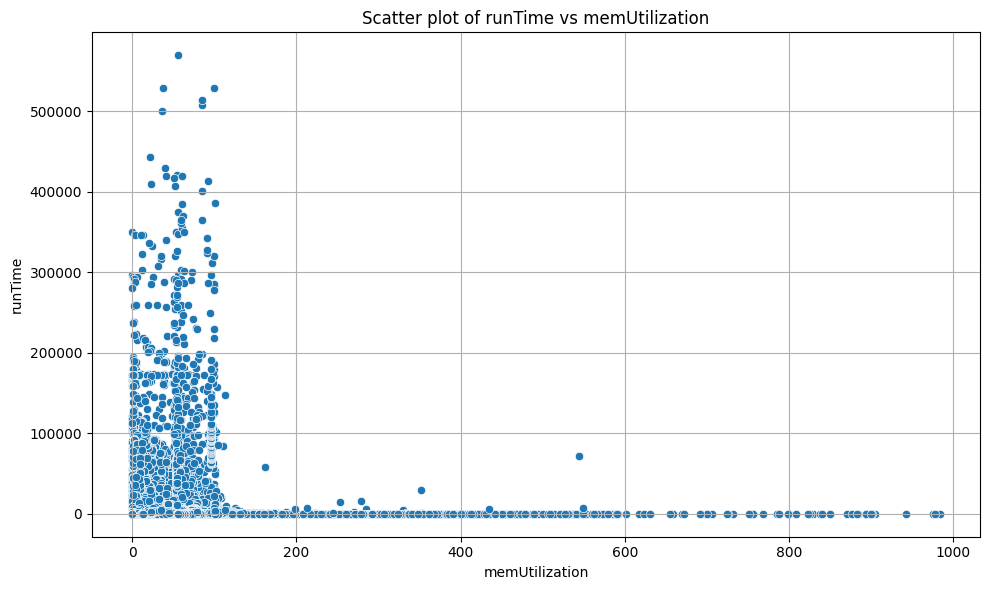

In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define columns of interest, excluding 'runTime'

corr_of_interest = [col for col in columns_of_interest if col != 'runTime']

# Create scatter plots and box plots
for var in corr_of_interest:
    if var in df_subset.columns:  # Check if the column exists in the DataFrame
        plt.figure(figsize=(10, 6))

        # Check if the variable is categorical
        if pd.api.types.is_categorical_dtype(df_subset[var]) or df_subset[var].dtype == 'object':
            # Box plot for categorical variables
            sns.boxplot(x=df_subset[var], y=df_subset['runTime'])
            plt.xlabel(var)
            plt.ylabel('runTime')
            plt.title(f'Box plot of runTime vs {var}')
            plt.xticks(rotation=90)
            plt.grid(True)

        # Scatter plot for numeric variables
        elif pd.api.types.is_numeric_dtype(df_subset[var]):
            sns.scatterplot(x=df_subset[var], y=df_subset['runTime'])
            plt.xlabel(var)
            plt.ylabel('runTime')
            plt.title(f'Scatter plot of runTime vs {var}')
            plt.grid(True)

        plt.tight_layout()
        plt.show()
    else:
        print(f"Column '{var}' not found in the DataFrame.")


In [128]:
import statsmodels.api as sm
# Create interaction term between 'submitDay' and 'submitInterval'
df_subset['submitDay_submitInterval'] = df_subset['submitDay'].astype(str) + '_' + df_subset['submitInterval'].astype(str)


X = pd.get_dummies(df_subset[['submitDay', 'submitInterval','submitDay_submitInterval', 'jStatus', 'queue', 'jobCategory', 'numProcessors', 'maxRMem', 'requested_memory', 'pendTime']], drop_first=True)
y = df_subset['runTime']

model = sm.OLS(y, sm.add_constant(X)).fit()
print(model.summary())




/tmp/ipykernel_273417/4225316918.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['submitDay_submitInterval'] = df_subset['submitDay'].astype(str) + '_' + df_subset['submitInterval'].astype(str)


                            OLS Regression Results                            
Dep. Variable:                runTime   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                 1.244e+04
Date:                Fri, 06 Sep 2024   Prob (F-statistic):               0.00
Time:                        13:13:56   Log-Likelihood:            -1.0371e+07
No. Observations:             1065184   AIC:                         2.074e+07
Df Residuals:                 1065128   BIC:                         2.074e+07
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

In [94]:
# Filter the DataFrame for jobs where jStatus is 'done'
df_done = df_subset[df_subset['jStatus'] == 'done']

# Calculate the percentiles
percentiles_done = df_done['runTime'].quantile([0.50, 0.75, 0.95, 0.975, 0.99])
print("Percentiles for jStatus='done':")
print(percentiles_done)

Percentiles for jStatus='done':
0.500      16.00
0.750     132.00
0.950     997.00
0.975    2624.00
0.990    8744.64
Name: runTime, dtype: float64


Step 1: Filtering data by the specified time range...
Data filtered from 2024-01-01 to 2024-12-31. Number of rows: 1065184
Step 2: Performing exploratory data analysis (EDA)...
Summary statistics for runTime:
count    1.065184e+06
mean     5.272468e+02
std      5.249282e+03
min      0.000000e+00
25%      7.000000e+00
50%      2.500000e+01
75%      1.230000e+02
max      5.692500e+05
Name: runTime, dtype: float64

Generating scatter plots for runTime vs candidate covariates...


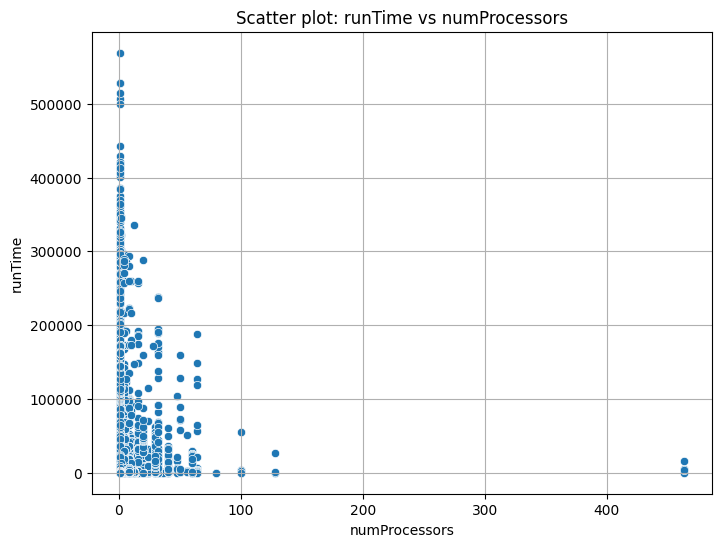

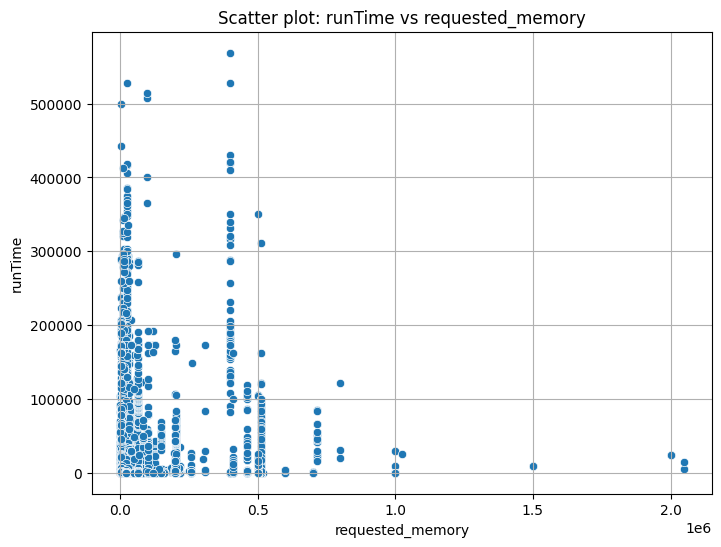

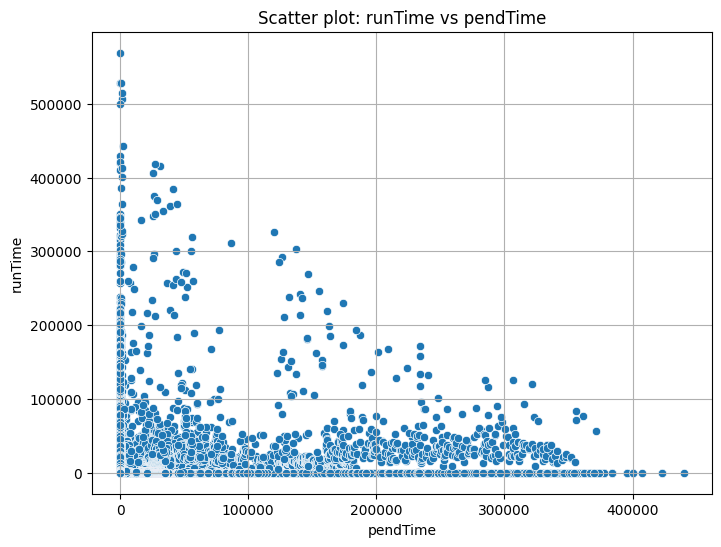

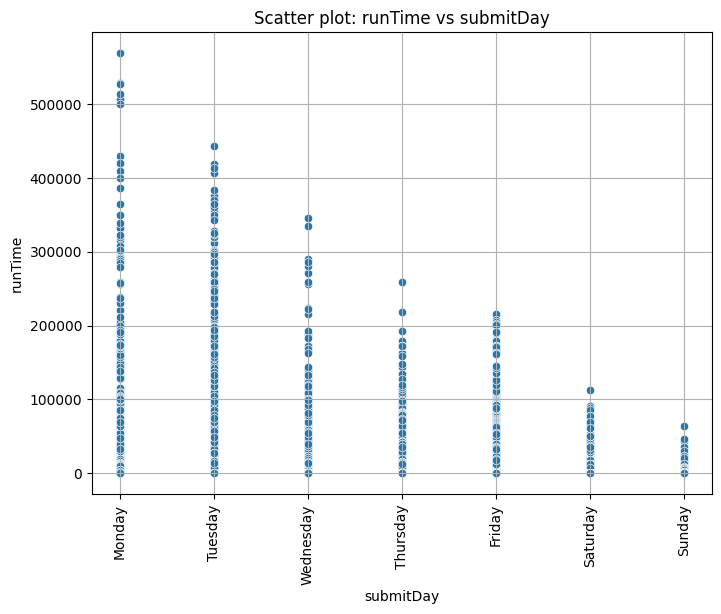

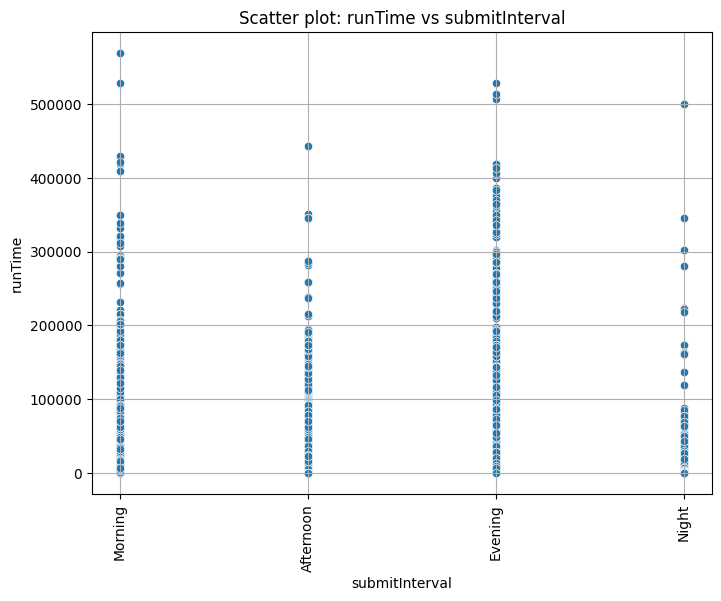

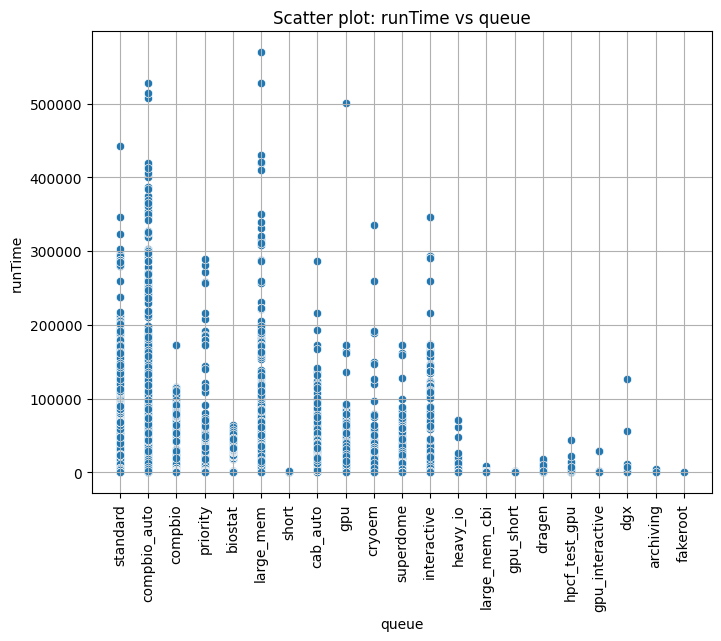

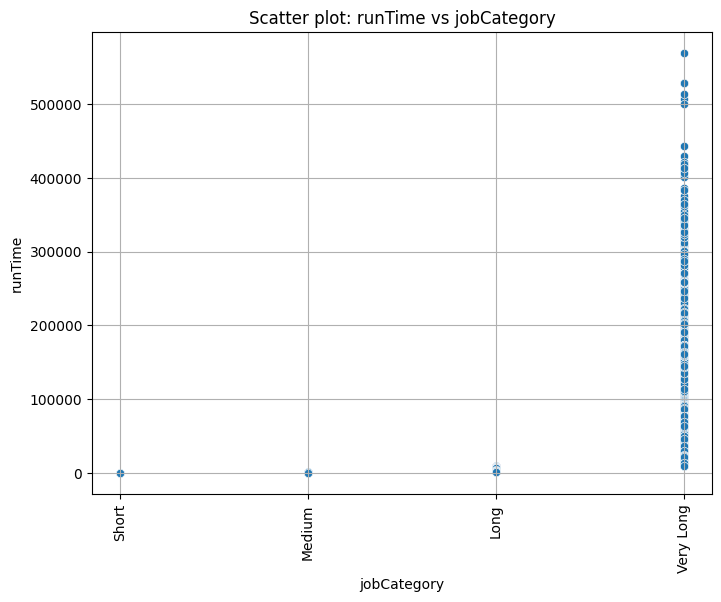

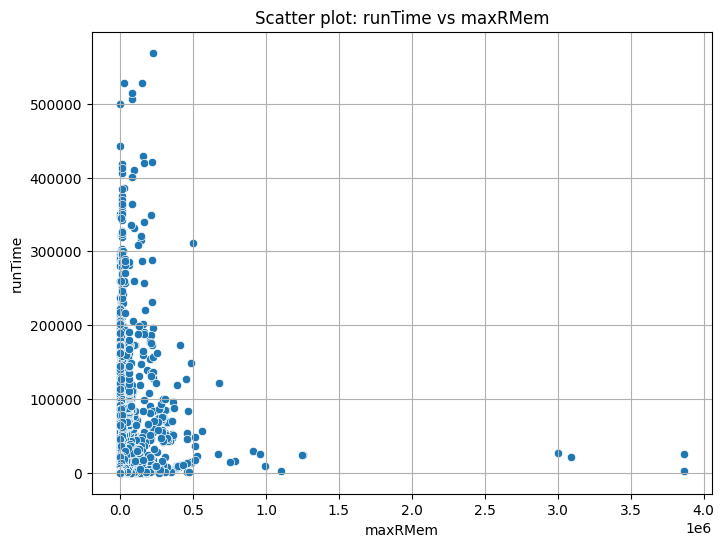

Step 3: Calculating correlation matrix for numeric variables...

Correlation matrix:
                    userId     jobId    jobIdx  numProcessors   maxRMem  \
userId            1.000000 -0.002149  0.223908      -0.066805  0.024679   
jobId            -0.002149  1.000000 -0.183766      -0.038079 -0.040961   
jobIdx            0.223908 -0.183766  1.000000      -0.035968  0.020941   
numProcessors    -0.066805 -0.038079 -0.035968       1.000000  0.174228   
maxRMem           0.024679 -0.040961  0.020941       0.174228  1.000000   
cpuTime          -0.029030 -0.034462 -0.021042       0.240098  0.249484   
runTime          -0.046769 -0.050233 -0.039858       0.090743  0.178782   
pendTime          0.089035 -0.075356  0.142218       0.023198  0.135583   
requested_memory -0.014474 -0.081257 -0.045245       0.034511  0.273838   
userCancelJob          NaN       NaN       NaN            NaN       NaN   
memUtilization   -0.162002  0.043071  0.181136      -0.032476  0.162529   

              

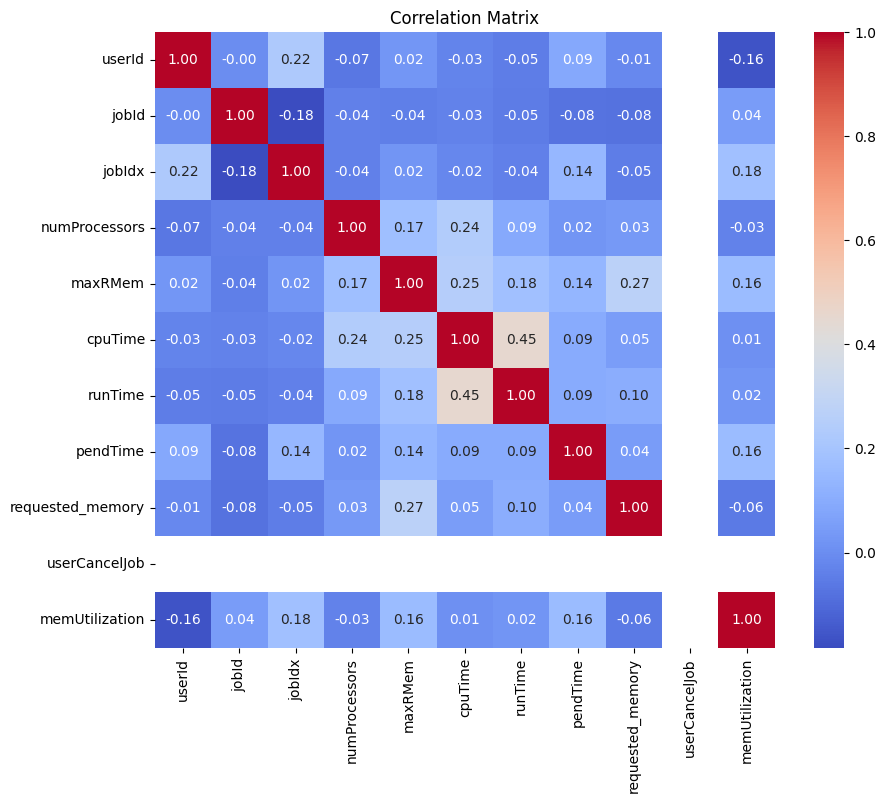

Step 4: Fitting a model to predict the variable of interest...

Model fitting completed. Here are the model results:
                            OLS Regression Results                            
Dep. Variable:                runTime   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                 1.896e+04
Date:                Fri, 06 Sep 2024   Prob (F-statistic):               0.00
Time:                        17:17:18   Log-Likelihood:            -1.0372e+07
No. Observations:             1065184   AIC:                         2.074e+07
Df Residuals:                 1065147   BIC:                         2.074e+07
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]


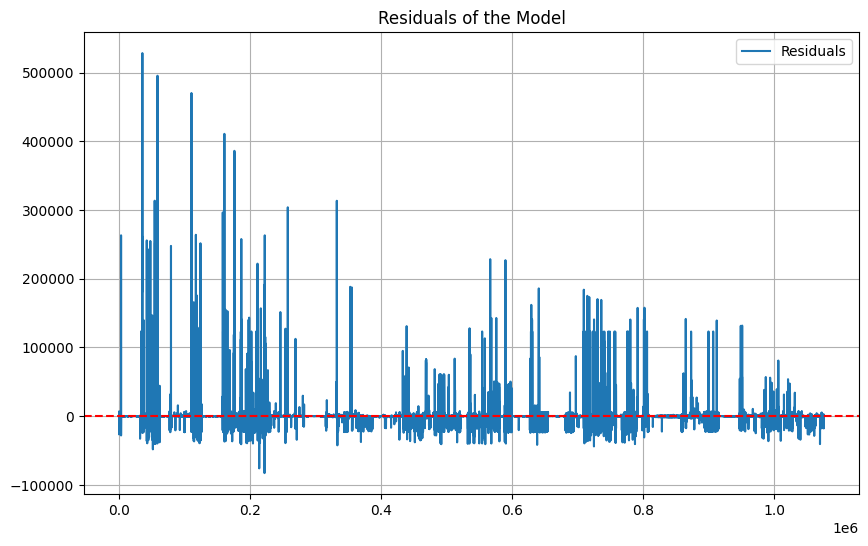


Report generation complete.


In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

def generate_report(df, startTime, endTime, variable_of_interest, candidate_covariates):
    """
    Generates a report with exploratory analysis, correlation matrix, model fitting, 
    and summary interpretation based on specified variables and time range.
    
    Arguments:
        df (DataFrame): The input dataframe.
        startTime (str): Start time in the format 'YYYY-MM-DD HH:MM:SS'.
        endTime (str): End time in the format 'YYYY-MM-DD HH:MM:SS'.
        variable_of_interest (str): The target variable for analysis (response).
        candidate_covariates (list of str): List of candidate covariate names.
    
    Output:
        A report with exploratory analysis, model results, and interpretation.
    """
    
    # Step 1: Filter data by the specified time range
    print("Step 1: Filtering data by the specified time range...")
    df_filtered = df[(df['startTime'] >= startTime) & (df['endTime'] <= endTime)]
    print(f"Data filtered from {startTime} to {endTime}. Number of rows: {len(df_filtered)}")
    
    # Step 2: Exploratory data analysis
    print("Step 2: Performing exploratory data analysis (EDA)...")
    print(f"Summary statistics for {variable_of_interest}:")
    print(df_filtered[variable_of_interest].describe())

    print(f"\nGenerating scatter plots for {variable_of_interest} vs candidate covariates...")
    for covariate in candidate_covariates:
        if covariate in df_filtered.columns:
            plt.figure(figsize=(8, 6))
            sns.scatterplot(x=df_filtered[covariate], y=df_filtered[variable_of_interest])
            plt.title(f'Scatter plot: {variable_of_interest} vs {covariate}')
            # Rotate x-axis labels if x-axis variable is categorical
            if df_filtered[covariate].dtype == 'object' or df_filtered[covariate].dtype.name == 'category':
                plt.xticks(rotation=90)
            plt.grid(True)
            plt.show()
        else:
            print(f"Warning: {covariate} not found in the dataframe.")

    # Step 3: Correlation matrix for numeric variables
    print("Step 3: Calculating correlation matrix for numeric variables...")
    numeric_vars = df_filtered.select_dtypes(include=[np.number]).columns
    corr_matrix = df_filtered[numeric_vars].corr()
    print(f"\nCorrelation matrix:\n{corr_matrix}")
    
    # Plot correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix')
    plt.show()
    
    # Step 4: Model fitting
    print("Step 4: Fitting a model to predict the variable of interest...")
    X = pd.get_dummies(df_filtered[candidate_covariates], drop_first=True)
    y = df_filtered[variable_of_interest]

    X = sm.add_constant(X)  # Add constant for the intercept
    model = sm.OLS(y, X).fit()
    print("\nModel fitting completed. Here are the model results:")
    print(model.summary())

    # Step 5: Interpretation of the model results
    print("Step 5: Interpreting the model results...")
    print(f"\nThe R-squared value of the model is {model.rsquared:.3f}, indicating how well the model explains the variance in {variable_of_interest}.")
    print(f"Key coefficients with p-values less than 0.05 are likely significant predictors.")
    
    # Step 6: Plotting the model summary results
    print("Step 6: Plotting the residuals of the model...")
    plt.figure(figsize=(10, 6))
    plt.plot(model.resid, label='Residuals')
    plt.axhline(0, color='r', linestyle='--')
    plt.title('Residuals of the Model')
    plt.legend()
    plt.grid(True)
    plt.show()

    print("\nReport generation complete.")
    
# Example usage
generate_report(df=df_preprocessed, 
                startTime='2024-01-01', 
                endTime='2024-12-31', 
                variable_of_interest='runTime', 
                candidate_covariates=['numProcessors', 'requested_memory', 'pendTime', 'submitDay', 'submitInterval', 'queue', 'jobCategory', 'maxRMem'])
